In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Problem 1
## Dataset Generation

Write a function to **generate a training set** of size $m$
- randomly generate a weight vector $w \in \mathbb{R}^{10}$, normalize length
- generate a training set $\{(x_i , y_i)\}$ of size m
  - $x_i$: random vector in $\mathbb{R}^{10}$ from $\textbf{N}(0, I)$
  - $y_i$: $\{0, +1\}$ with $P[y = +1] = \sigma(w \cdot x_i)$ and $P[y = 0] = 1 - \sigma(w \cdot x_i)$

In [2]:
def generate_data(m):
    # generate weight vector
    w_star = np.random.normal(size=(10,))
    w_star /= np.linalg.norm(w_star)
    
    # training sample
    X = np.zeros((m, 10))
    Y = np.zeros((m,))
    for i in range(m):
        X[i, :] = np.random.normal(size=(10,))
        prob = 1.0 / (1.0 + np.exp(-w_star.dot(X[i])))
        Y[i] = np.random.choice([0.0, 1.0], p=[1-prob, prob])
    return w_star, X, Y

## Algorithm 1: logistic regression

The goal is to learn $w$.  Algorithm 1 is logistic
  regression (you may use the built-in method LogisticRegression for this. Use max_iter=1000).

In [21]:
def log_reg(X, Y):
    return LogisticRegression(max_iter=1000).fit(X, Y).coef_

## Algorithm 2: gradient descent with square loss

Define square loss as
$$L_i(w^{(t)}) = \frac{1}{2} \left( \sigma(w^{(t)} \cdot x) - y_i \right)^2$$

  Algorithm 2 is
  gradient descent with respect to square loss (code this
  up yourself -- run for 1000 iterations, use step size eta = 0.01).

## Algorithm 3: stochastic gradient descent with square loss
Similar to gradient descent, except we use the gradient at a single random training point every iteration.

The gradient of the loss is given by $$ \nabla_w L(w) = (\sigma(w \cdot x) - y) \sigma'(w \cdot x) x. $$ The derivative of the sigmoid function satisfies $$ \sigma'(t) = \frac{e^{-t}}{(1 + e^{-t})^2} = \frac{1}{1 + e^{-t}} - \frac{1}{(1 + e^{-t})^2} = \sigma(t) - \sigma(t)^2. $$ Denoting $\sigma(w \cdot x)$ by $\hat{y}$, this means that one convenient way to simplify the gradient above is as follows: $$ \nabla_w L(w) = (\hat{y} - y)(1 - \hat{y})\hat{y} x. $$

In [20]:
def gradient(w, xi, yi):
    yhat = 1.0 / (1.0 + np.exp(-w.dot(xi)))
    return (yhat - yi) * yhat * (1 - yhat) * xi

In [18]:
def gd(X, Y, n_iter=1000, eta=0.01):
    w = np.zeros(X.shape[1])
    for t in range(n_iter):
        grad = np.mean([gradient(w, x, y) for x, y in zip(X, Y)], axis=0)
        w = w - eta * grad
    return w

In [ ]:
def sgd(X, Y, n_iter=1000, eta=0.01):
    w = np.zeros(X.shape[1])
    for t in range(n_iter):
        i = np.random.randint(X.shape[0])
        w = w - eta * gradient(w, X[i], Y[i])
    return w

## Evaluation

Measure error $\|w - \hat{w}\|_2$ for each method at different sample size. For any
  fixed value of $m$, choose many different $w$'s and average the
  values $\|w - 
  \hat{w}\|_2$ for Algorithms 1, 2 and 3.  Plot the results
  for for each algorithm as you make $m$ large (use $m=50, 100, 150, 200, 250$).
  Also record, for each algorithm, the time taken to run the overall experiment.

In [87]:
ms = [50, 100, 150, 200, 250]

def run_trials(model, num_trials=10):
    errs = []
    for m in ms:
        trial_errs = []
        for _ in range(num_trials):
            w, X, Y = generate_data(m)
            w_hat = model(X, Y)
            trial_errs.append(np.linalg.norm(w - w_hat))
        errs.append(np.mean(trial_errs))
    return errs

In [ ]:
%%time
logreg_errs = run_trials(log_reg)

In [24]:
%%time
gd_errs = run_trials(gd)

CPU times: user 1.99 s, sys: 18.6 ms, total: 2.01 s
Wall time: 2.1 s


In [25]:
%%time
sgd_errs = run_trials(sgd)

CPU times: user 1min 1s, sys: 590 ms, total: 1min 1s
Wall time: 1min 9s


(It is worth noting that true GD takes much longer than either SGD or logistic regression.)

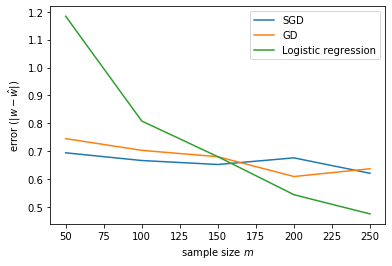

In [23]:
plt.plot(ms, sgd_errs, label='SGD')
plt.plot(ms, gd_errs, label='GD')
plt.plot(ms, logreg_errs, label='Logistic regression')
plt.xlabel('sample size $m$')
plt.ylabel('error ($\|w - \hat{w}\|$)')
plt.legend()
plt.show()

**PEER GRADERS TAKE NOTE**: The plot may differ slightly due to randomness, but logistic regression should perform better than SGD when the sample size is large. You should also observe that SGD and GD have similar performance, but that SGD runs much faster than GD.

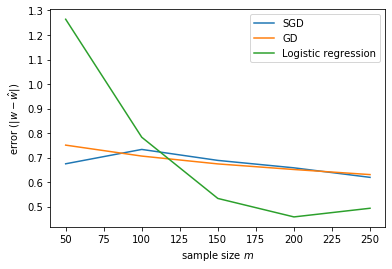

In [26]:
plt.plot(ms, sgd_errs, label='SGD')
plt.plot(ms, gd_errs, label='GD')
plt.plot(ms, logreg_errs, label='Logistic regression')
plt.xlabel('sample size $m$')
plt.ylabel('error ($\|w - \hat{w}\|$)')
plt.legend()
plt.show()

# Problem 2

In [27]:
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [88]:
cancer = datasets.load_breast_cancer()

For each depth in $1, \dots, 5$, instantiate an AdaBoost classifier with the base learner set to be a decision tree of that depth, and then record the 10-fold cross-validated error on the entire breast cancer data set. Plot the resulting curve of accuracy against base classifier depth. Use $101$ as your random state for both the base learner as well as the AdaBoost classifier every time.

In [85]:
accuracy = []
for depth in range(1, 6):
    dt = DecisionTreeClassifier(max_depth=depth, random_state=101)
    ada = AdaBoostClassifier(base_estimator=dt, n_estimators=10, learning_rate=1, random_state=101)
    accuracy.append(np.mean(cross_val_score(ada, cancer.data, cancer.target, cv=10)))

Text(0, 0.5, 'accuracy')

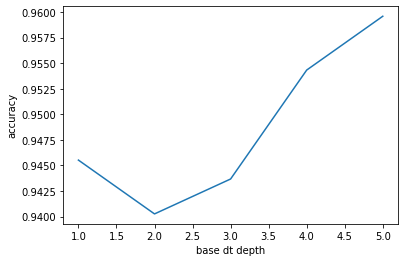

In [86]:
plt.plot(range(1, 6), accuracy)
plt.xlabel('base dt depth')
plt.ylabel('accuracy')